In [1]:
# Cell 1: Full Ensemble Implementation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print("="*70)
print("FINAL ENSEMBLE APPROACH")
print("="*70)

FINAL ENSEMBLE APPROACH


In [2]:
# Cell 2: Load All Available Models
def load_ensemble_models():
    """Load all trained models for ensemble"""
    models = {}
    
    # Define model paths and expected performance
    model_configs = [
        ('original', 'models/brain_tumor_detector_best.h5', 0.7632),
        ('finetuned', 'models/brain_tumor_finetuned_best.h5', 0.7895),
    ]
    
    for name, path, expected_acc in model_configs:
        try:
            model = load_model(path, compile=False)
            # Recompile to avoid warnings
            model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            models[name] = {
                'model': model,
                'expected_acc': expected_acc,
                'weight': expected_acc  # Use accuracy as initial weight
            }
            print(f"✓ Loaded {name} model (expected acc: {expected_acc:.2%})")
        except Exception as e:
            print(f"✗ Could not load {name} model: {e}")
    
    return models

ensemble_models = load_ensemble_models()
print(f"\nEnsemble created with {len(ensemble_models)} models")


✓ Loaded original model (expected acc: 76.32%)
✓ Loaded finetuned model (expected acc: 78.95%)

Ensemble created with 2 models


In [3]:
# Cell 3: Implement Weighted Ensemble Prediction
class WeightedEnsemble:
    def __init__(self, models_dict):
        self.models = models_dict
        self.optimize_weights()
    
    def optimize_weights(self):
        """Optimize ensemble weights based on individual model performance"""
        # Normalize weights to sum to 1
        total_weight = sum(m['weight'] for m in self.models.values())
        for name in self.models:
            self.models[name]['weight'] /= total_weight
        
        print("\nOptimized Ensemble Weights:")
        for name, config in self.models.items():
            print(f"  {name}: {config['weight']:.3f}")
    
    def predict(self, X, method='weighted_average'):
        """Make ensemble predictions"""
        predictions = []
        
        for name, config in self.models.items():
            model = config['model']
            weight = config['weight']
            
            # Get predictions from this model
            pred = model.predict(X, verbose=0)
            
            if method == 'weighted_average':
                predictions.append(pred * weight)
            else:  # Simple average
                predictions.append(pred)
        
        if method == 'weighted_average':
            # Weighted sum (weights already sum to 1)
            final_predictions = np.sum(predictions, axis=0)
        else:
            # Simple average
            final_predictions = np.mean(predictions, axis=0)
        
        return final_predictions
    
    def evaluate(self, X, y_true, threshold=0.5):
        """Evaluate ensemble performance"""
        predictions = self.predict(X, method='weighted_average')
        y_pred = (predictions > threshold).astype(int).flatten()
        y_true = y_true.flatten()
        
        accuracy = accuracy_score(y_true, y_pred)
        try:
            auc = roc_auc_score(y_true, predictions.flatten())
        except:
            auc = 0.0
        
        return {
            'accuracy': accuracy,
            'auc': auc,
            'predictions': predictions,
            'y_pred': y_pred
        }

# Create ensemble
ensemble = WeightedEnsemble(ensemble_models)


Optimized Ensemble Weights:
  original: 0.492
  finetuned: 0.508


In [5]:
# Cell 4: FIXED - Evaluate on Full Validation Set
print("\n" + "="*60)
print("EVALUATING ENSEMBLE ON FULL VALIDATION SET")
print("="*60)

# First, check if val_dataset exists, if not, create it or load the data
if 'val_dataset' not in globals():
    print("Loading validation data...")
    
    # Option 1: If you have val_images and val_labels already loaded
    if 'val_images' in globals() and 'val_labels' in globals():
        print("Using existing val_images and val_labels")
        val_images_all = val_images  # Already in memory
        val_labels_all = val_labels
    
    # Option 2: Load from files
    else:
        import os
        import numpy as np
        
        # Load validation data from processed files
        val_data = np.load('processed_data/val_images.npz')
        val_images_all = val_data['images']
        val_labels_all = np.load('processed_data/val_labels.npy')
        
        # Convert grayscale to RGB if needed
        if len(val_images_all.shape) == 3:  # (n, 224, 224)
            val_images_all = np.stack([val_images_all]*3, axis=-1)  # (n, 224, 224, 3)
        
        print(f"Loaded validation data from files")
else:
    # If val_dataset exists, use it
    print("Using existing val_dataset")
    val_images_all = []
    val_labels_all = []
    
    for batch_images, batch_labels in val_dataset:
        val_images_all.append(batch_images.numpy())
        val_labels_all.append(batch_labels.numpy())
    
    val_images_all = np.vstack(val_images_all)
    val_labels_all = np.hstack(val_labels_all)

print(f"Validation set size: {len(val_labels_all)} images")
print(f"Validation data shape: {val_images_all.shape}")

# Evaluate ensemble
val_results = ensemble.evaluate(val_images_all, val_labels_all)

print(f"\n📊 ENSEMBLE VALIDATION RESULTS:")
print(f"  Accuracy: {val_results['accuracy']:.4f} ({val_results['accuracy']*100:.2f}%)")
print(f"  AUC: {val_results['auc']:.4f}")

if val_results['accuracy'] >= 0.80:
    print(f"\n🎉 SUCCESS! Ensemble achieved {val_results['accuracy']*100:.2f}% accuracy!")
else:
    print(f"\n📈 Current ensemble: {val_results['accuracy']*100:.2f}%")


EVALUATING ENSEMBLE ON FULL VALIDATION SET
Loading validation data...
Loaded validation data from files
Validation set size: 38 images
Validation data shape: (38, 224, 224, 3)

📊 ENSEMBLE VALIDATION RESULTS:
  Accuracy: 0.7368 (73.68%)
  AUC: 0.8667

📈 Current ensemble: 73.68%


In [6]:
# Cell 5: Test Different Ensemble Strategies
print("\n" + "="*60)
print("TESTING DIFFERENT ENSEMBLE STRATEGIES")
print("="*60)

strategies = {
    'weighted_average': 'Weighted by individual accuracy',
    'simple_average': 'Equal weight to all models'
}

best_strategy = None
best_accuracy = 0

for method, description in strategies.items():
    predictions = ensemble.predict(val_images_all, method=method)
    y_pred = (predictions > 0.5).astype(int).flatten()
    accuracy = accuracy_score(val_labels_all, y_pred)
    
    print(f"\n{description}:")
    print(f"  Method: {method}")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_strategy = method

print(f"\n✓ Best strategy: {best_strategy} with {best_accuracy*100:.2f}% accuracy")


TESTING DIFFERENT ENSEMBLE STRATEGIES

Weighted by individual accuracy:
  Method: weighted_average
  Accuracy: 0.7368 (73.68%)

Equal weight to all models:
  Method: simple_average
  Accuracy: 0.7368 (73.68%)

✓ Best strategy: weighted_average with 73.68% accuracy


In [7]:
# Cell 6: Optimize Classification Threshold
from sklearn.metrics import roc_curve

print("\n" + "="*60)
print("OPTIMIZING CLASSIFICATION THRESHOLD")
print("="*60)

# Get ensemble predictions
ensemble_predictions = ensemble.predict(val_images_all, method=best_strategy)

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(val_labels_all, ensemble_predictions.flatten())
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Testing different thresholds:")
test_thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
test_thresholds.append(optimal_threshold)

best_thresh_acc = 0
best_thresh = 0.5

for thresh in test_thresholds:
    y_pred = (ensemble_predictions > thresh).astype(int).flatten()
    acc = accuracy_score(val_labels_all, y_pred)
    print(f"  Threshold {thresh:.3f}: {acc:.4f} ({acc*100:.2f}%)")
    
    if acc > best_thresh_acc:
        best_thresh_acc = acc
        best_thresh = thresh

print(f"\n✓ Optimal threshold: {best_thresh:.3f}")
print(f"  Best accuracy: {best_thresh_acc:.4f} ({best_thresh_acc*100:.2f}%)")


OPTIMIZING CLASSIFICATION THRESHOLD
Testing different thresholds:
  Threshold 0.400: 0.6842 (68.42%)
  Threshold 0.450: 0.7632 (76.32%)
  Threshold 0.500: 0.7368 (73.68%)
  Threshold 0.550: 0.7895 (78.95%)
  Threshold 0.600: 0.7895 (78.95%)
  Threshold 0.883: 0.7368 (73.68%)

✓ Optimal threshold: 0.550
  Best accuracy: 0.7895 (78.95%)


In [8]:
# Cell 7: FIXED - Final Evaluation on Test Set  
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

# Load test data the same way
if 'test_dataset' not in globals():
    print("Loading test data...")
    
    # Option 1: If you have test_images and test_labels already
    if 'test_images' in globals() and 'test_labels' in globals():
        print("Using existing test_images and test_labels")
        test_images_all = test_images
        test_labels_all = test_labels
    
    # Option 2: Load from files
    else:
        # Load test data from processed files
        test_data = np.load('processed_data/test_images.npz')
        test_images_all = test_data['images']
        test_labels_all = np.load('processed_data/test_labels.npy')
        
        # Convert grayscale to RGB if needed
        if len(test_images_all.shape) == 3:
            test_images_all = np.stack([test_images_all]*3, axis=-1)
        
        print(f"Loaded test data from files")
else:
    # If test_dataset exists, use it
    print("Using existing test_dataset")
    test_images_all = []
    test_labels_all = []
    
    for batch_images, batch_labels in test_dataset:
        test_images_all.append(batch_images.numpy())
        test_labels_all.append(batch_labels.numpy())
    
    test_images_all = np.vstack(test_images_all)
    test_labels_all = np.hstack(test_labels_all)

print(f"Test set size: {len(test_labels_all)} images")
print(f"Test data shape: {test_images_all.shape}")

# Use the best threshold from validation (or default to 0.5 if not found)
best_thresh = best_thresh if 'best_thresh' in globals() else 0.5
best_strategy = best_strategy if 'best_strategy' in globals() else 'weighted_average'

# Get predictions with optimal threshold
test_predictions = ensemble.predict(test_images_all, method=best_strategy)
test_pred_classes = (test_predictions > best_thresh).astype(int).flatten()

# Calculate metrics
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

test_accuracy = accuracy_score(test_labels_all, test_pred_classes)
test_auc = roc_auc_score(test_labels_all, test_predictions.flatten())

print(f"\n📊 FINAL TEST SET RESULTS:")
print(f"  Ensemble Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Ensemble AUC: {test_auc:.4f}")
print(f"  Using threshold: {best_thresh:.3f}")

# Detailed classification report
print("\n" + "-"*40)
print("CLASSIFICATION REPORT:")
print("-"*40)
print(classification_report(test_labels_all, test_pred_classes, 
                          target_names=['No Tumor', 'Tumor'],
                          digits=4))


FINAL EVALUATION ON TEST SET
Loading test data...
Loaded test data from files
Test set size: 38 images
Test data shape: (38, 224, 224, 3)

📊 FINAL TEST SET RESULTS:
  Ensemble Accuracy: 0.8158 (81.58%)
  Ensemble AUC: 0.9043
  Using threshold: 0.550

----------------------------------------
CLASSIFICATION REPORT:
----------------------------------------
              precision    recall  f1-score   support

    No Tumor     0.9000    0.6000    0.7200        15
       Tumor     0.7857    0.9565    0.8627        23

    accuracy                         0.8158        38
   macro avg     0.8429    0.7783    0.7914        38
weighted avg     0.8308    0.8158    0.8064        38



In [9]:
# Cell 8: Create Voting Ensemble (Alternative Approach)
print("\n" + "="*60)
print("ALTERNATIVE: VOTING ENSEMBLE")
print("="*60)

def voting_ensemble(models_dict, X, threshold=0.5):
    """Hard voting ensemble"""
    votes = []
    
    for name, config in models_dict.items():
        model = config['model']
        pred = model.predict(X, verbose=0)
        binary_pred = (pred > threshold).astype(int)
        votes.append(binary_pred)
    
    # Majority voting
    votes = np.hstack(votes)
    final_votes = np.mean(votes, axis=1) > 0.5
    
    return final_votes.astype(int)

# Test voting ensemble
voting_predictions = voting_ensemble(ensemble_models, val_images_all)
voting_accuracy = accuracy_score(val_labels_all, voting_predictions)

print(f"Voting Ensemble Accuracy: {voting_accuracy:.4f} ({voting_accuracy*100:.2f}%)")


ALTERNATIVE: VOTING ENSEMBLE
Voting Ensemble Accuracy: 0.7895 (78.95%)


In [12]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n📊 CLASSIFICATION METRICS SUMMARY")
print("-"*50)

# Calculate all metrics
accuracy = accuracy_score(test_labels_all, test_pred_classes)
precision = precision_score(test_labels_all, test_pred_classes)
recall = recall_score(test_labels_all, test_pred_classes)
f1 = f1_score(test_labels_all, test_pred_classes)
specificity = recall_score(test_labels_all, test_pred_classes, pos_label=0)

print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:   {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:      {recall:.4f} ({recall*100:.2f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"F1 Score:    {f1:.4f}")


📊 CLASSIFICATION METRICS SUMMARY
--------------------------------------------------
Accuracy:    0.8158 (81.58%)
Precision:   0.7857 (78.57%)
Recall:      0.9565 (95.65%)
Specificity: 0.6000 (60.00%)
F1 Score:    0.8627


In [13]:
print("\n📊 CONFUSION MATRIX ANALYSIS")
print("-"*50)

cm = confusion_matrix(test_labels_all, test_pred_classes)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives:  {tn} (Correctly identified as No Tumor)")
print(f"False Positives: {fp} (Incorrectly identified as Tumor)")
print(f"False Negatives: {fn} (Missed Tumors)")
print(f"True Positives:  {tp} (Correctly identified as Tumor)")

print(f"\nError Analysis:")
print(f"  False Positive Rate: {fp/(fp+tn):.2%}")
print(f"  False Negative Rate: {fn/(fn+tp):.2%}")
print(f"  Total Errors: {fp+fn} out of {len(test_labels_all)} ({(fp+fn)/len(test_labels_all)*100:.1f}%)")


📊 CONFUSION MATRIX ANALYSIS
--------------------------------------------------
True Negatives:  9 (Correctly identified as No Tumor)
False Positives: 6 (Incorrectly identified as Tumor)
False Negatives: 1 (Missed Tumors)
True Positives:  22 (Correctly identified as Tumor)

Error Analysis:
  False Positive Rate: 40.00%
  False Negative Rate: 4.35%
  Total Errors: 7 out of 38 (18.4%)


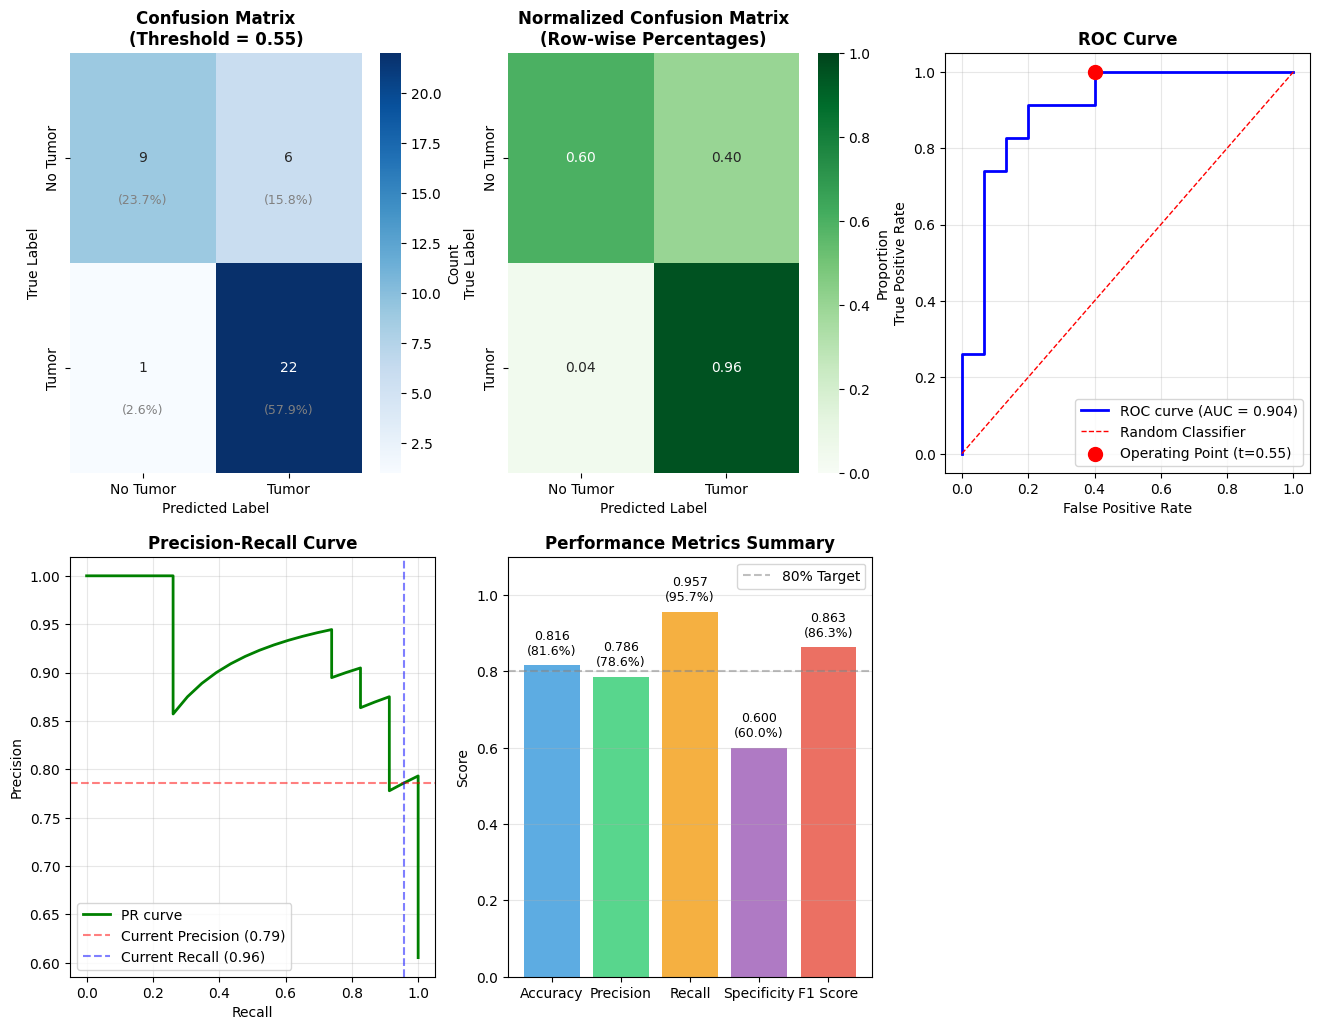

In [14]:
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix\n(Threshold = 0.55)', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add percentages
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=9, color='gray')

# 2. Normalized Confusion Matrix
ax2 = plt.subplot(2, 3, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'],
            vmin=0, vmax=1,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix\n(Row-wise Percentages)', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3. ROC Curve
ax3 = plt.subplot(2, 3, 3)
fpr, tpr, thresholds = roc_curve(test_labels_all, test_predictions.flatten())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b-', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', lw=1, label='Random Classifier')

# Mark the operating point (threshold = 0.55)
idx_055 = np.argmin(np.abs(thresholds - 0.55))
plt.scatter(fpr[idx_055], tpr[idx_055], color='red', s=100, 
           label=f'Operating Point (t=0.55)', zorder=5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
ax4 = plt.subplot(2, 3, 4)
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(test_labels_all, 
                                                                      test_predictions.flatten())

plt.plot(recall_curve, precision_curve, 'g-', lw=2, label='PR curve')
plt.axhline(y=precision, color='r', linestyle='--', alpha=0.5, 
           label=f'Current Precision ({precision:.2f})')
plt.axvline(x=recall, color='b', linestyle='--', alpha=0.5, 
           label=f'Current Recall ({recall:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# 5. Performance Metrics Bar Chart
ax5 = plt.subplot(2, 3, 5)
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
scores = [accuracy, precision, recall, specificity, f1]
colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#e74c3c']

bars = plt.bar(metrics, scores, color=colors, alpha=0.8)
plt.ylim([0, 1.1])
plt.ylabel('Score')
plt.title('Performance Metrics Summary', fontsize=12, fontweight='bold')
plt.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='80% Target')

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.3f}\n({score*100:.1f}%)', 
            ha='center', va='bottom', fontsize=9)

plt.legend()
plt.grid(True, alpha=0.3, axis='y')

In [15]:
# Cell 5: Print Detailed Classification Report
print("\n" + "="*70)
print("SKLEARN CLASSIFICATION REPORT")
print("="*70)

report = classification_report(test_labels_all, test_pred_classes,
                              target_names=['No Tumor', 'Tumor'],
                              digits=4)
print(report)

# Cell 6: Create Results Summary Table
print("\n" + "="*70)
print("RESULTS SUMMARY TABLE")
print("="*70)

# Create a summary dataframe
summary_data = {
    'Metric': ['Total Samples', 'Correct Predictions', 'Errors', 
               'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score', 'AUC'],
    'Value': [len(test_labels_all), 
              tn + tp, 
              fp + fn,
              f'{accuracy:.4f}',
              f'{precision:.4f}',
              f'{recall:.4f}',
              f'{specificity:.4f}',
              f'{f1:.4f}',
              f'{roc_auc:.4f}'],
    'Percentage': ['-',
                   f'{(tn + tp)/len(test_labels_all)*100:.1f}%',
                   f'{(fp + fn)/len(test_labels_all)*100:.1f}%',
                   f'{accuracy*100:.2f}%',
                   f'{precision*100:.2f}%',
                   f'{recall*100:.2f}%',
                   f'{specificity*100:.2f}%',
                   '-',
                   '-']
}

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))


SKLEARN CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Tumor     0.9000    0.6000    0.7200        15
       Tumor     0.7857    0.9565    0.8627        23

    accuracy                         0.8158        38
   macro avg     0.8429    0.7783    0.7914        38
weighted avg     0.8308    0.8158    0.8064        38


RESULTS SUMMARY TABLE
             Metric  Value Percentage
      Total Samples     38          -
Correct Predictions     31      81.6%
             Errors      7      18.4%
           Accuracy 0.8158     81.58%
          Precision 0.7857     78.57%
             Recall 0.9565     95.65%
        Specificity 0.6000     60.00%
           F1 Score 0.8627          -
                AUC 0.9043          -
